In [802]:
# Preliminary stuff
import pandas as pd
import os
import ast
import numpy as np
import math
import random
from copy import deepcopy
%matplotlib inline
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import pickle
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist
import seaborn as sns
from scipy.stats import spearmanr
from scipy.optimize import curve_fit

In [803]:
CHARACTER_DICT = set([u'A', u'C', u'E', u'D', u'G', u'F', u'I', u'H', u'K', u'M', u'L', u'N', u'Q', u'P', u'S', u'R', u'T', u'W', u'V', u'Y'])
MAX_SEQUENCE_LENGTH=46
MAX_MIC = 4
FONT_TO_USE = 'Arial'

In [804]:
fname = 'Hemolysis/Hemolytik_data.csv'
hemolysis_df = pd.read_csv(fname)

In [805]:
hemolysis_df.columns

Index([u'ID', u'PMID', u'Year', u'Sequence', u'Name', u'C-ter MOD',
       u'N-ter MOD', u'Linear Cyclic', u'Stereochemistry', u'Modified',
       u'Length', u'Function', u'Activity', u'Source', u'DSSP'],
      dtype='object')

In [806]:
print set(hemolysis_df['Linear Cyclic'])
print set(hemolysis_df['Modified'])
print set(hemolysis_df['C-ter MOD'])
print set(hemolysis_df['N-ter MOD'])
print set(hemolysis_df['Stereochemistry'])

set(['Linear'])
set(['K*: Acetylated Lysin', '*=palmitate(PAL)', 'Nala', 'Spacer = 8-amino-3,6-dioxaoctanoic acid', 'Tic= tetrahydroisoquinolinecarboxylic acid, Oic= octahydroindolecarboxylic acid', '*=_-GalNAc', 'Acm=acetamidomethyl', 'Modified somehow??? -JW', 'Met (O)= methionine sulfoxide', 'Spacer = 8-amino-octanoic acid', 'Tic= tetrahydroisoquinolinecarboxylic acid, Oic= octahydroindolecarboxylic acid, GABA= _-aminobutyric acid', 'Tic= tetrahydroisoquinolinecarboxylic acid', 'Aib (_-aminoisobutyric acid)', 'O= Orinithine', '_F = _, _-dehydrophenylalanine (_Phe)', 'l, lauric acid', 'X: Pcm arg', 'X; Nle', 'Met (O2)=methionine sulfone', 'Z= pyroglutamic acid', 'Abu 2 =aminobutyric acid', 'l, lauric acid; alK, aminolauryl-lysine', 'Tic- tetrahydroisoquinolinecarboxylic acid, Oic- octahydroindolecarboxylic acid, _Ala- _-alanine', 'Nle= norleucine', "Modified somehow??? There's an X -JW", 'Nle= norleucine, Met (O)= methionine sulfoxide', 'Tic= tetrahydroisoquinolinecarboxylic acid, Oi

In [807]:
hemolysis_df = hemolysis_df.loc[hemolysis_df['N-ter MOD']=='Free'].reset_index(drop=True)
hemolysis_df = hemolysis_df[hemolysis_df['Modified']=='None'].reset_index(drop=True)
for cterm_mod in set(hemolysis_df['C-ter MOD']):
    if cterm_mod != 'Free' and cterm_mod != 'Amidation':
        hemolysis_df = hemolysis_df[hemolysis_df['C-ter MOD'] != cterm_mod].reset_index(drop=True)
acceptable_animals = ['Sheep','Horse','Rabbit','Guinea-pig','Dog','Bovine','Rat','Human','Porcine','Pig','Mouse']
for animal in set(hemolysis_df['Source']):
    if animal not in acceptable_animals:
        hemolysis_df = hemolysis_df[hemolysis_df['Source'] != animal].reset_index(drop=True)
hemolysis_df = hemolysis_df[hemolysis_df['Linear Cyclic']=='Linear']

In [808]:
print set(hemolysis_df['Linear Cyclic'])
print set(hemolysis_df['Modified'])
print set(hemolysis_df['C-ter MOD'])
print set(hemolysis_df['N-ter MOD'])
print set(hemolysis_df['Source'])

set(['Linear'])
set(['None'])
set(['Amidation', 'Free'])
set(['Free'])
set(['Sheep', 'Horse', 'Rabbit', 'Guinea-pig', 'Dog', 'Bovine', 'Rat', 'Human', 'Porcine', 'Pig', 'Mouse'])


In [809]:
def str_to_float_with_scientific(string):
    try:
        return float(string)
    except:
        if 'x10' in string:
            before = float(string[0:string.index('x10')])
            if 'g' in string:
                after = float(string[string.index('x10')+3:string.index('g')])
            else:
                after = float(string[string.index('x10')+3:])
            return before*np.power(10,after)
        else:
            return 

# Returns: percent hemolysis, concentration, units, hemolysis greater than/less than/equal, concentration greater than/less than/equal
# For MHC ("minimun hemolytic concentration"): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1855469/
# The hemolytic activity was determined as the maximal peptide concentration that caused no hemolysis of erythrocytes after 18 h. The control for no release of hemoglobin was a sample of 1% erythrocytes without any peptide added. Since erythrocytes were in an isotonic medium, no detectable release (<1% of that released upon complete hemolysis) of hemoglobin was observed from this control during the course of the assay.
# So I called it 1% hemolysis at the MHC, pretty arbitrarily
# However! "The minimal hemolytic concentration (MHC) value was determined as the lowest peptide concentration that produces 5% or more hemolysis (Chen et al., 2002; Dathe et al., 2002; Zhu et al., 2007)"
# in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3906872/
# So as a compromise I just went for 3%

def parse_activity(activity,mhc_percent_hemolysis=3.0):
    hemo_gle = 'ERROR'
    conc_gle = 'ERROR'
    percent_hemolysis = 'ERROR'
    conc = 'ERROR'
    units = 'ERROR'
    if activity=='<20% hemolysis at 2.15 to 215microM':
        return 'ERROR','ERROR','ERROR','ERROR','ERROR'
    if 'Non hemolytic' in activity or 'non-hemolytic' in activity or 'Non-hemolytic' in activity or 'non hemolytic' in activity or 'Not detected hemolysis' in activity or 'Non hemolysis' in activity or 'Low hemolytic activity' in activity or 'No hemolysis' in activity:
        if 'up to' not in activity:
            return 'non','non','non','non','non'
    if 'EC50' in activity or 'IC50' in activity or 'HC10' in activity or 'HL50' in activity or 'HC50' in activity or 'LC50' in activity or 'HD50' in activity or 'LD50' in activity or 'EC25' in activity or 'MHC' in activity:
        hemo_gle = 'Equal'
        if 'EC25' in activity:
            percent_hemolysis = 25
        if 'HC10' in activity:
            percent_hemolysis = 10
        elif 'MHC' in activity:
            percent_hemolysis = mhc_percent_hemolysis
        else:
            percent_hemolysis = 50
        if '=' in activity:
            conc_gle = 'Equal'
            start_parse = activity.index('=')+1
            if '+' in activity:
                end_parse = activity.index('+')
            else:
                if 'm' in activity[start_parse:]:
                    end_parse = activity.index('m')
                elif 'M' in activity[start_parse:]:
                    end_parse = activity.index('M')
            if '-' in activity[start_parse:end_parse] and 'x' not in activity[start_parse:end_parse]:
                newstr = activity[start_parse:end_parse]
                dash_ind = newstr.index('-')
                lower = float(newstr[0:dash_ind])
                upper = float(newstr[dash_ind+1:])
                conc_gle = 'Equal'
                conc = (lower+upper)/2
            else:
                to_convert = activity[start_parse:end_parse]
                conc = str_to_float_with_scientific(to_convert)
        if '~' in activity:
            conc_gle = 'Equal'
            start_parse = activity.index('~')+1
            if '+' in activity:
                end_parse = activity.index('+')
            else:
                if 'm' in activity[start_parse:]:
                    end_parse = activity.index('m')
                elif 'M' in activity[start_parse:]:
                    end_parse = activity.index('M')
            to_convert = activity[start_parse:end_parse]
            conc = str_to_float_with_scientific(to_convert)
        elif '>' in activity:
            conc_gle = 'Greater'
            start_parse = activity.rfind('>')+1
            if '+' in activity:
                end_parse = activity.index('+')
            else:
                end_parse = activity.index('m')
            to_convert = activity[start_parse:end_parse]
            conc = str_to_float_with_scientific(to_convert)
        elif '<' in activity:
            conc_gle = 'Less'
            start_parse = activity.index('<')+1
            if '+' in activity:
                end_parse = activity.index('+')
            else:
                end_parse = activity.index('m')
            to_convert = activity[start_parse:end_parse]
            conc = str_to_float_with_scientific(to_convert)
    if '%' in activity or 'fraction' in activity or 'Negligible' in activity or 'No hemolysis' in activity or 'little hemolysis' in activity or 'Little hemolysis' in activity or 'Low hemolytic activity' in activity or 'Non-hemolytic' in activity:
        parse=True
        if '+-' in activity:
            end_hemo_parse = min(activity.index('%'),activity.index('+'))
        elif '%' in activity:
            end_hemo_parse = activity.index('%')
        elif 'fraction' in activity:
            end_hemo_parse = activity.index('fraction')
        elif 'Negligible' in activity or 'No hemolysis' in activity or 'little hemolysis' in activity or 'Little hemolysis' in activity or 'Low hemolytic activity' in activity or 'Non-hemolytic' in activity:
            percent_hemolysis = 0
            hemo_gle = 'Equal'
            parse = False
        if parse:
            try:
                percent_hemolysis = float(activity[0:end_hemo_parse])
                if 'fraction' in activity:
                    percent_hemolysis = percent_hemolysis*100
                hemo_gle = 'Equal'
            except:
                if '-' in activity[0:end_hemo_parse]:
                    try:
                        dash_ind = activity[0:end_hemo_parse].index('-')
                        lower = float(activity[0:dash_ind])
                        upper = float(activity[dash_ind+1])
                        hemo_gle = 'Equal'
                        percent_hemolysis = (lower+upper)/2
                    except:
                        dash_ind = activity[0:end_hemo_parse].index('-')
                        lower = float(activity[1:dash_ind])
                        upper = float(activity[dash_ind+1])
                        hemo_gle = 'Equal'
                        percent_hemolysis = (lower+upper)/2
                        if activity[0]=='>':
                            hemo_gle = 'Greater'
                        elif activity[0]=='<':
                            hemo_gle = 'Less'
                        elif activity[0]=='~':
                            hemo_gle = 'Equal'
    #                     print 'Does this work: '+activity+',' + repr(percent_hemolysis)+','+repr(hemo_gle)
                else:
                    try:
                        percent_hemolysis = float(activity[1:end_hemo_parse])
                        if activity[0]=='>':
                            hemo_gle = 'Greater'
                        elif activity[0]=='<':
                            hemo_gle = 'Less'
                        elif activity[0]=='~':
                            hemo_gle = 'Equal'
                    except:
                        return 'Per_hemo_parse_error: '+activity[0:end_hemo_parse],'ERROR','ERROR','ERROR','ERROR'
        if 'at' in activity:
            if '~' in activity[activity.index('at'):] and activity.index('~')>activity.index('at'):
                start_parse = activity.index('~')+1
            else:
                start_parse = activity.index('at')+2
        elif 'up to' in activity:
            start_parse = activity.index('up to')+5
        elif 'upto' in activity:
            start_parse = activity.index('upto')+4
        else:
            try:
                start_parse = activity.index('hemolysis')+len('hemolysis')
            except:
                print activity
        if 'micro' in activity:
            end_parse = activity.index('micro')
        elif 'mM' in activity:
            end_parse = activity.index('mM')
        elif 'g/l' in activity:
            end_parse = activity.index('g/l')
        elif 'M' in activity:
            end_parse = activity.index('M')
        elif 'mg/' in activity:
            end_parse = activity.index('mg/')
        else:
            print 'ERROR in end parse: '+activity
        if '-' in activity[start_parse:end_parse]: #and hemo_gle == 'Less':
            newstr = activity[start_parse:end_parse]
            start_parse = newstr.index('-')+1+start_parse
        if '>' in activity[start_parse:end_parse]:
            newstr = activity[start_parse:end_parse]
            start_parse = newstr.index('>')+1+start_parse
        conc = str_to_float_with_scientific(activity[start_parse:end_parse])
        conc_gle = 'Equal'
    if 'microg/ml' in activity or 'microg/mL' in activity:
        units = 'ug/ml'
    elif 'microM' in activity:
        units = 'uM'
    elif 'mM' in activity:
        units = 'mM'
    elif 'g/l' in activity:
        units = 'mg/ml'
    elif 'mg/ml' in activity or 'mg/mL' in activity:
        units = 'mg/ml'
    elif 'g/ml' in activity:
        units = 'g/ml'
    elif activity.endswith('microg'):
        units = 'ug/ml'
    elif activity.endswith('M'):
        units = 'M'
    elif activity.endswith('mg/L'):
        units = 'ug/ml'
    return percent_hemolysis,hemo_gle,conc,conc_gle,units
        
# Standardize units of MIC
def standardize_to_uM(concentration, unit, sequence):
    if unit == 'uM':
        return concentration
    elif unit == 'mM':
        return concentration*1000
    elif unit == 'M':
        return concentration*1000000
    elif unit == 'ug/ml' or unit == u'\xb5g/ml' or unit == u'ug/ml)':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
#         print concentration
#         print sequence
        return concentration * 1000/molWt
    elif unit == 'mg/ml':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000000/molWt
    elif unit == 'g/ml':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000000000/molWt
    else:
        # print 'Unit not recognized: ' + unit
        return None

In [811]:
print parse_activity('LC50 =40microM')
print parse_activity('LC50 =5 +- 1microM')
print parse_activity('10.2% hemolysis up to 200microg/ml')
print parse_activity('7.62 +- 1.60% hemolysis at 100microg/ml')
print parse_activity('<10% hemolysis at 100microM')
print parse_activity('MHC =62.5microg/ml')
print parse_activity('0-3% hemolysis upto 80microg/ml')
print parse_activity('0.2 fractions hemolysis at 5.0microM')
print parse_activity('No or little hemolysis upto 800microM')
print parse_activity('Non-hemolytic up to 250microM')
print parse_activity('HC50=0.6 +- 0.1microMol/L')
print parse_activity('<1% hemolysis at 3-100microg/ml')
print parse_activity('1.5-2.3% hemolysis at 3-100microg/ml')
print parse_activity('50% hemolysis at >18microg/ml')
print parse_activity('EC50 =7-14microg/ml')
print parse_activity('1.2% hemolysis at 200microg/ml')
print parse_activity('100% hemolysis at ~25microM')
print parse_activity('IC50>>100microM')
print parse_activity('~1.4% hemolytic at 100microg/ml')
print parse_activity('~90% hemolysis at 20microM')

(50, 'Equal', 40.0, 'Equal', 'uM')
(50, 'Equal', 5.0, 'Equal', 'uM')
(10.2, 'Equal', 200.0, 'Equal', 'ug/ml')
(7.62, 'Equal', 100.0, 'Equal', 'ug/ml')
(10.0, 'Less', 100.0, 'Equal', 'uM')
(3.0, 'Equal', 62.5, 'Equal', 'ug/ml')
(1.5, 'Equal', 80.0, 'Equal', 'ug/ml')
(20.0, 'Equal', 5.0, 'Equal', 'uM')
(0, 'Equal', 800.0, 'Equal', 'uM')
(0, 'Equal', 250.0, 'Equal', 'uM')
(50, 'Equal', 0.6, 'Equal', 'uM')
(1.0, 'Less', 100.0, 'Equal', 'ug/ml')
(1.75, 'Equal', 100.0, 'Equal', 'ug/ml')
(50.0, 'Equal', 18.0, 'Equal', 'ug/ml')
(50, 'Equal', 10.5, 'Equal', 'ug/ml')
(1.2, 'Equal', 200.0, 'Equal', 'ug/ml')
(100.0, 'Equal', 25.0, 'Equal', 'uM')
(50, 'Equal', 100.0, 'Greater', 'uM')
(1.4, 'Equal', 100.0, 'Equal', 'ug/ml')
(90.0, 'Equal', 20.0, 'Equal', 'uM')


In [812]:
wrong=0
right=0
for i,activity in enumerate(hemolysis_df.Activity[0:]):
#     print activity
    a,b,c,d,e = parse_activity(activity)
    if c==None or a==None or b==None or d==None:
        print i
        print activity
        print repr(a)+','+repr(b)+','+repr(c)+','+repr(d)+','+repr(e)
        wrong += 1
    else:
        right += 1

In [813]:
# First pick what value to assign for 'non-hemolytic'
sequence_dict = {}
all_zeros = []
for i,row in hemolysis_df.iterrows():
    percent_hemolysis,hemo_gle,conc,conc_gle,units = parse_activity(row['Activity'])
    if percent_hemolysis=='ERROR' or hemo_gle=='ERROR' or conc=='ERROR' or conc_gle=='ERROR' or units=='ERROR':
        pass
    elif percent_hemolysis=='non':
        pass
#         seq = row['Sequence']
#         if seq not in sequence_dict:
#             sequence_dict[seq]=[]
#         sequence_dict[seq].append(['max'])
    else:
        seq = row['Sequence']
        if seq not in sequence_dict:
            sequence_dict[seq]=[]
        conc_in_uM = standardize_to_uM(conc,units,seq)
        if percent_hemolysis == 0:
            all_zeros.append(conc_in_uM)
            if conc_in_uM==None:
                print repr(conc)+' is none??? Seq: '+seq+', units = '+units
        if percent_hemolysis==None:
            print repr(percent_hemolysis)+' is none??? Seq: '+seq+', units = '+units
        sequence_dict[seq].append([percent_hemolysis,conc_in_uM,hemo_gle,conc_gle])
print all_zeros

[61.91720048065085, 61.91720048065085, 61.91720048065085, 200.0, 200.0, 25.0, 50.0, 109935.83292787621, 0.78, 6.25, 5.0, 0.5, 0.5, 5.0, 0.5, 5.0, 15.0, 100.0, 50.0, 10.0, 60.0, 60.0, 10.0, 14.0, 14.0, 50.0, 50.0, 50.0, 200.0, 50.0, 50.0, 200.0, 50.0, 50.0, 200.0, 50.0, 50.0, 200.0, 50.0, 50.0, 200.0, 50.0, 50.0, 200.0, 50.0, 50.0, 200.0, 50.0, 50.0, 200.0, 50.0, 50.0, 43.46096151727431, 38.158989046271394, 33.19714343560308, 29.995422698496206, 12.5, 16.0, 32.0, 200.0, 200.0, 0.9146715746053623, 1.8264208758094296, 3.652841751618859, 0.9146715746053623, 1.8264208758094296, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 250.0, 250.0, 400.0, 400.0, 125.0, 200.0, 165.15891032940576, 107.45969052683722, 98.40358873951988, 200.0, 100.0, 421.0873712870786, 429.57483099586455, 319.5950092043363, 254.45053871154832, 128.7625731622905, 213.4839533785737, 12.5, 50.0, 12.5, 100.0, 100.0, 800.0, 800.0, 800.0, 800.0, 800.0, 32.0, 8.0, 8.0, 32.429401598088475, 38.49493627342941, 38.49493627342941, 38.494

In [814]:
# First pick what value to assign for 'non-hemolytic'
sequence_dict = {}
all_hundreds = []
for i,row in hemolysis_df.iterrows():
    percent_hemolysis,hemo_gle,conc,conc_gle,units = parse_activity(row['Activity'])
    if percent_hemolysis=='ERROR' or hemo_gle=='ERROR' or conc=='ERROR' or conc_gle=='ERROR' or units=='ERROR':
        pass
    elif percent_hemolysis=='non':
        pass
#         seq = row['Sequence']
#         if seq not in sequence_dict:
#             sequence_dict[seq]=[]
#         sequence_dict[seq].append(['max'])
    else:
        seq = row['Sequence']
        if seq not in sequence_dict:
            sequence_dict[seq]=[]
        conc_in_uM = standardize_to_uM(conc,units,seq)
        if percent_hemolysis == 100:
            all_hundreds.append(conc_in_uM)
            if conc_in_uM==None:
                print repr(conc)+' is none??? Seq: '+seq+', units = '+units
        sequence_dict[seq].append([percent_hemolysis,conc_in_uM,hemo_gle,conc_gle])
print all_hundreds

[52.430980774450674, 8.662200062172634, 16.289725851944056, 34.96580878671852, 34.965808786718526, 2.0, 25.0, 64.0, 200.0, 50.0, 50.0, 770.0, 770.0, 770.0, 770.0, 5000000.0, 5000000.0, 100.0, 100.0, 100.0, 100.0, 5.0, 20.0, 100.0, 41.10514976825739, 46.28297708400213, 3000000.0, 200.0, 139.27913160575676, 100.0, 19.596392696032513, 225.0, 50.0, 50.0, 50.0, 50.0, 50.0, 100.0, 1.0, 1.0, 5.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 40.33964366379166, 100.0, 0.4, 40.0, 40.0, 100.0, 200.0, 48.0, 48.0, 32.0, 64.0, 120.0, 80.0, 80.0, 42.45885084140378, 10.0, 1.0, 10.0, 40.0, 100.0, 100.0, 100.0, 50.0, 25.0, 90.0, 20.0, 25.336382279795043, 30.0, 10.933996166759623, 10.0, 70.0, 70.0, 80.0, 1.0, 90.0, 58.24076206872351, 4.1226265854701625, 16.781870819566052, 28.47957467789474, 40.0, 175.0, 85.0, 63.0, 330.0, 365.0, 54.018927151695415, 61.207945481303945, 100.0, 25.0, 25.0]


In [815]:
NON_HEMOLYTIC_VAL = 1000
ALL_HEMOLYTIC_VAL = 1

In [816]:
# Just sequence dict for fitting
sequence_dict = {}
all_zeros = []
for i,row in hemolysis_df.iterrows():
    percent_hemolysis,hemo_gle,conc,conc_gle,units = parse_activity(row['Activity'])
    if percent_hemolysis=='ERROR' or hemo_gle=='ERROR' or conc=='ERROR' or conc_gle=='ERROR' or units=='ERROR':
        pass
    elif percent_hemolysis=='non':
        seq = row['Sequence']
        if seq not in sequence_dict:
            sequence_dict[seq]=[]
        sequence_dict[seq].append([0,NON_HEMOLYTIC_VAL,'Non','Non'])
    else:
        seq = row['Sequence']
        if seq not in sequence_dict:
            sequence_dict[seq]=[]
        conc_in_uM = standardize_to_uM(conc,units,seq)
        if percent_hemolysis == 0:
            all_zeros.append(conc_in_uM)
        if conc_in_uM==None:
            print repr(conc)+' is none??? Seq: '+seq+', units = '+units
        if row['Source']=='Human':
            sequence_dict[seq].append([percent_hemolysis,conc_in_uM,hemo_gle,conc_gle])

[  1.16383723 147.83091644]


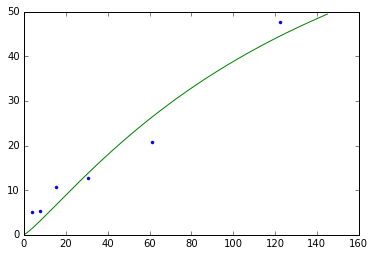

[  1.27881467 103.73841444]


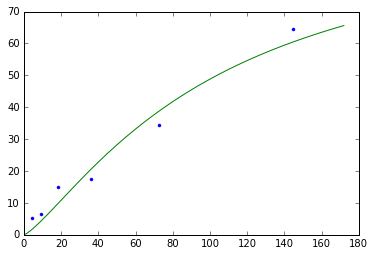

[ 3.23022525 12.7794951 ]


/Users/jacobwitten/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in power


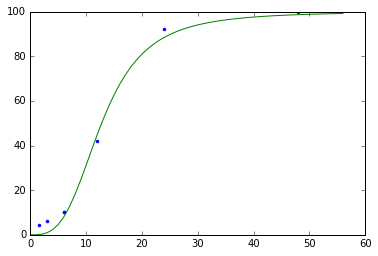

[ 1.07084879 99.99629116]


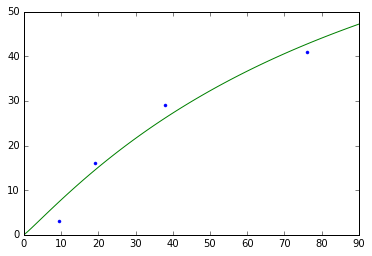

[  1.45435411 105.84556799]


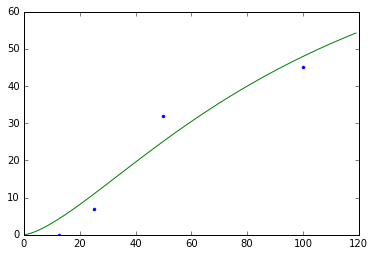

[ 5.62595101 24.72077029]


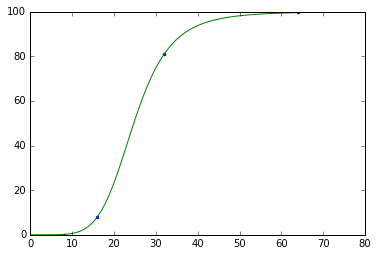

[  2.6449569  129.20568307]


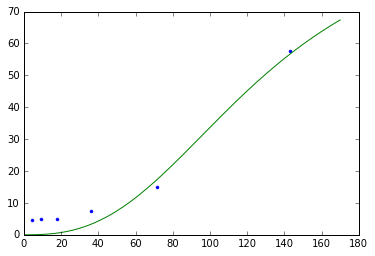

[ 0.95788981 15.4111158 ]


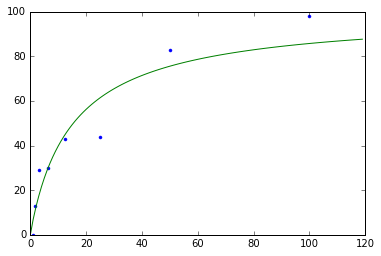

[ 1.31508942 27.13965687]


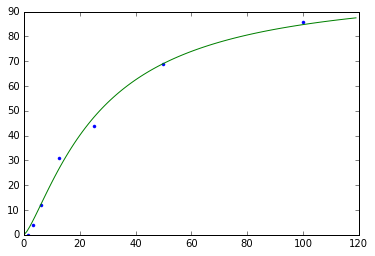

[ 1.4591001  90.20191697]


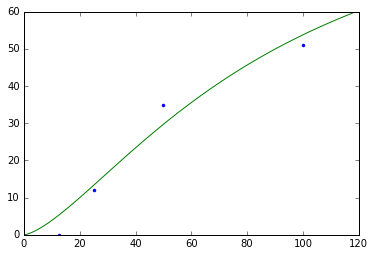

10


In [817]:
plots = []
counter=0
k_vals=[]
n_vals=[]
def hill_function(x,n,k):
    return 100*np.power(x,n)/(np.power(k,n)+np.power(x,n))

for key,val in sequence_dict.items():
    if len(val)>=4:
        hemo_vals = [row[0] for row in val if row[2]=='Equal' and row[3]=='Equal']
        conc_vals = [row[1] for row in val if row[2]=='Equal' and row[3]=='Equal']
        if len(hemo_vals)>=4 and max(hemo_vals)-min(hemo_vals)>20 and max(conc_vals)-min(conc_vals)>5:
#             print key
#             print hemo_vals
#             print conc_vals
            if spearmanr(hemo_vals,conc_vals)[0]==1:
                counter+=1
                fit,cov = curve_fit(hill_function,conc_vals,hemo_vals,p0=[2,40])
                print fit
                plt.plot(conc_vals,hemo_vals,'.')
                conc_vals.sort()
                plt.plot(range(int(max(conc_vals)*1.2)),hill_function(range(int(max(conc_vals)*1.2)),*fit))
                plt.show()
                k_vals.append(fit[1])
                n_vals.append(fit[0])
print counter

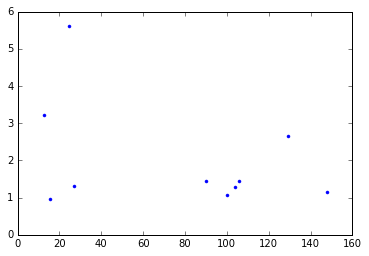

In [818]:
plt.plot(k_vals,n_vals,'.')

In [819]:
print np.mean(n_vals)
print np.std(n_vals)

2.020106729484931
1.3892767268071264


In [820]:
n_for_conversion = np.mean(n_vals)
std_of_n_for_conversion = np.std(n_vals)

In [821]:
# Just sequence dict for fitting
sequence_dict = {}
all_zeros = []
for i,row in hemolysis_df.iterrows():
    percent_hemolysis,hemo_gle,conc,conc_gle,units = parse_activity(row['Activity'])
    if percent_hemolysis=='ERROR' or hemo_gle=='ERROR' or conc=='ERROR' or conc_gle=='ERROR' or units=='ERROR':
        pass
    elif percent_hemolysis=='non':
        seq = row['Sequence']
        if seq not in sequence_dict:
            sequence_dict[seq]=[]
        sequence_dict[seq].append([0,NON_HEMOLYTIC_VAL,'Non','Non'])
    else:
        seq = row['Sequence']
        if seq not in sequence_dict:
            sequence_dict[seq]=[]
        conc_in_uM = standardize_to_uM(conc,units,seq)
        if percent_hemolysis == 0:
            all_zeros.append(conc_in_uM)
        if conc_in_uM==None:
            print repr(conc)+' is none??? Seq: '+seq+', units = '+units
#         if row['Source']=='Human':
        sequence_dict[seq].append([percent_hemolysis,conc_in_uM,hemo_gle,conc_gle])

In [822]:
def combine_ranges(all_ranges):
    avg = np.average([ran[0] for ran in all_ranges])
    if avg<-10000000:
        return [np.log((NON_HEMOLYTIC_VAL-ALL_HEMOLYTIC_VAL)/2),np.log((NON_HEMOLYTIC_VAL-ALL_HEMOLYTIC_VAL)/2)]
    elif avg>np.log(NON_HEMOLYTIC_VAL):
        return [np.log(NON_HEMOLYTIC_VAL),0]
    elif avg < np.log(ALL_HEMOLYTIC_VAL):
        return [np.log(ALL_HEMOLYTIC_VAL),0]
    if np.average([ran[1] for ran in all_ranges])<-0.0001:
        print 'WTFFFFFF: '+repr([ran[1] for ran in all_ranges])
        print 'Returning: '+repr([np.average([ran[0] for ran in all_ranges]),np.average([ran[1] for ran in all_ranges])])
    return [np.average([ran[0] for ran in all_ranges]),np.average([ran[1] for ran in all_ranges])]

def range_to_val_and_uncertainty(ranges):
    first_val = max(min(ranges[0],np.log(NON_HEMOLYTIC_VAL)),np.log(ALL_HEMOLYTIC_VAL))
    return [first_val,float(ranges[2]-ranges[1])/2]

def row_to_hc50_with_error(row):
    if abs(row[0]-50)<0.01 and row[2]=='Equal' and row[3]=='Equal':
        low_n_estimate = np.log(row[1])
        high_n_estimate = np.log(row[1])
        point_estimate = np.log(row[1])
        low_estimate = min(low_n_estimate, high_n_estimate)
        high_estimate = max(low_n_estimate,high_n_estimate)
        return [point_estimate,low_estimate,high_estimate]
    elif abs(row[0]-3)<0.01 and row[2]=='Equal' and row[3]=='Equal':
        y = float(row[0])/100
        x = row[1]
#             print repr(x)+','+repr(np.log(x*np.power((1-y)/y,1/n_for_conversion)))+','+repr(np.log(x*np.power((1-y)/y,1/(n_for_conversion-1))))+','+repr(np.log(x*np.power((1-y)/y,1/(n_for_conversion+1))))
#             print repr(np.log(x*np.power((1-.01)/.01,1/n_for_conversion)))
        low_n_estimate = np.log(x*np.power((1-y)/y,1/n_low))
        high_n_estimate = np.log(x*np.power((1-y)/y,1/n_high))
        point_estimate = np.log(x*np.power((1-y)/y,1/n_estimate))
        low_estimate = min(low_n_estimate, high_n_estimate)
        high_estimate = max(low_n_estimate,high_n_estimate)
        return [point_estimate,low_estimate,high_estimate]
    elif row[0]>=0.1 and row[0]<=99.9 and row[2]=='Equal' and row[3]=='Equal':
        y = float(row[0])/100
        x = row[1]
#             print x
#             print y
#             print x*np.power((1-y)/y,1/n_for_conversion)
        low_n_estimate = np.log(x*np.power((1-y)/y,1/n_low))
        high_n_estimate = np.log(x*np.power((1-y)/y,1/n_high))
        point_estimate = np.log(x*np.power((1-y)/y,1/n_estimate))
        low_estimate = min(low_n_estimate, high_n_estimate)
        high_estimate = max(low_n_estimate,high_n_estimate)
        return [point_estimate,low_estimate,high_estimate]
    elif abs(row[0]-50)<0.001 and row[2]=='Greater' and row[3]=='Equal':
        x = row[1]
        max_y = 0.99
        point_y = 0.75
        high_estimate = np.log(x)
        low_estimate = np.log(x*np.power((1-max_y)/max_y,1/n_low))
        point_estimate = np.log(x*np.power((1-point_y)/point_y,1/n_estimate))
        return [point_estimate,low_estimate,high_estimate]
#             print key
#             print row
#             print repr([point_estimate,low_estimate,high_estimate])
    elif (row[2]=='Equal' and row[3]=='Greater') or row[2]=='Non' or (row[0]<0.1 and row[1]):
        return [np.log(NON_HEMOLYTIC_VAL),np.log(NON_HEMOLYTIC_VAL),np.log(NON_HEMOLYTIC_VAL)]
    elif row[2]=='Less' and row[3]=='Equal':
        max_y = float(row[0])/100
        x = float(row[1])
        low_estimate = np.log(x*np.power((1-max_y)/max_y,1/n_low))
#             print key
#             print row
#             print repr(low_estimate) + 'vs. '+repr(np.log(NON_HEMOLYTIC_VAL))
        if low_estimate>=np.log(NON_HEMOLYTIC_VAL):
            return [np.log(NON_HEMOLYTIC_VAL),np.log(NON_HEMOLYTIC_VAL),np.log(NON_HEMOLYTIC_VAL)]
    elif abs(row[0]-50)<0.01 and row[2]=='Equal' and row[3]=='Less' and row[1]<5.1:
        return [np.log(ALL_HEMOLYTIC_VAL),np.log(ALL_HEMOLYTIC_VAL),np.log(ALL_HEMOLYTIC_VAL)]
    elif row[0]>50.1 and row[2]=='Greater' and row[3]=='Equal':
        x = float(row[1])
        max_y = 0.99
        min_y = float(row[0])/100
        point_y = (1+float(row[0]/100))/2
        high_estimate = np.log(x*np.power((1-min_y)/min_y,1/n_high))
        low_estimate = np.log(x*np.power((1-max_y)/max_y,1/n_low))
        point_estimate = np.log(x*np.power((1-point_y)/point_y,1/n_estimate))
        return [point_estimate,low_estimate,high_estimate]
    elif row[0]>99.9 and row[2]=='Equal' and row[3]=='Equal':
        y=0.99
        x=float(row[1])
        high_estimate = max(np.log(ALL_HEMOLYTIC_VAL),np.log(x*np.power((1-y)/y,1/n_high)))
        low_estimate = np.log(ALL_HEMOLYTIC_VAL)
        point_estimate = np.average([high_estimate,low_estimate])
#         print key
#         print row
#         print repr([point_estimate,low_estimate,high_estimate])
        return [point_estimate,low_estimate,high_estimate]
#         print key
#         print row
#         print repr([point_estimate,low_estimate,high_estimate])
#     elif abs(row[0]-50)<48:
#         pass
#         print key
#         print row
    else:
        pass
#         print key
#         print row

sequence_log_hc50_dict={}
c0=0
c1=0
c2=0
c3=0
c4=0
c5=0
c6=0
c7=0
c8=0
c9=0
c10=0
lengths = []
n_low = n_for_conversion - std_of_n_for_conversion
n_estimate = n_for_conversion
n_high = n_for_conversion + std_of_n_for_conversion
for key,val in sequence_dict.items():
    c0+=1
    if len(val)==1:
        row = val[0]
        estimate_with_error = row_to_hc50_with_error(row)
        if not estimate_with_error is None:
            vals_with_uncertainty = range_to_val_and_uncertainty(estimate_with_error)
            sequence_log_hc50_dict[key] = vals_with_uncertainty
            c1+=1
        else:
            c3 +=1
    elif len(val)>1 and len(val)<4:
        all_ranges = []
        for row in val:
            if row[0]<99.9 and row[0]>0.1:
                estimate_with_error = row_to_hc50_with_error(row)
                if not estimate_with_error is None:
                    vals_with_uncertainty = range_to_val_and_uncertainty(estimate_with_error)
                    all_ranges.append(vals_with_uncertainty)
        if len(all_ranges)>0:
            sequence_log_hc50_dict[key] = combine_ranges(all_ranges)
            c2 +=1
        else:
            c4 +=1
    else:
        hemo_vals = [row[0] for row in val if row[2]=='Equal' and row[3]=='Equal']
        conc_vals = [row[1] for row in val if row[2]=='Equal' and row[3]=='Equal']
        rows_in_case = [row for row in val if row[2]=='Equal' and row[3]=='Equal']
        if len(hemo_vals)>=4 and max(hemo_vals)-min(hemo_vals)>3 and max(conc_vals)-min(conc_vals)>5:
            try:
                fit,cov = curve_fit(hill_function,conc_vals,hemo_vals,p0=[2,40])
                if fit[1]>NON_HEMOLYTIC_VAL:
                    to_set = [np.log(NON_HEMOLYTIC_VAL),0]
                elif fit[1]<ALL_HEMOLYTIC_VAL:
                    to_set = [np.log(ALL_HEMOLYTIC_VAL),0]
                else:
                    to_set = [np.log(fit[1]),cov[1][1]/fit[1]]
                if to_set[1]<np.log(NON_HEMOLYTIC_VAL-ALL_HEMOLYTIC_VAL):   
                    sequence_log_hc50_dict[key] = to_set
#                     print key
#     #                 print conc_vals
#     #                 print hemo_vals
#                     print to_set
#                     print np.exp(to_set[0])
#                     plt.plot(conc_vals,hemo_vals,'.')
#                     conc_vals.sort()
#                     plt.plot(range(int(max(conc_vals)*1.2)),hill_function(range(int(max(conc_vals)*1.2)),*fit))
#                     plt.show()
                    c5+=1
                else:
                    c7+=1
            except:
                c7+=1
        elif len(rows_in_case)>0:
            all_ranges = []
            for row in rows_in_case:
                if row[0]<99.9 and row[0]>0.1:
                    estimate_with_error = row_to_hc50_with_error(row)
                    if not estimate_with_error is None:
                        vals_with_uncertainty = range_to_val_and_uncertainty(estimate_with_error)
                        all_ranges.append(vals_with_uncertainty)
            if len(all_ranges)>0:
                if combine_ranges(all_ranges)[1]>-0.01:
                    sequence_log_hc50_dict[key] = combine_ranges(all_ranges)
                    c8 +=1
                else:
                    print key
                    print hemo_vals
                    print conc_vals
                    print combine_ranges(all_ranges)
                    c9+=1
            else:
                c9 +=1
        else:
#             print key
#             print len(val)
#             print hemo_vals
#             print conc_vals
            c6+=1
        
            
print 'c0 (all):'+repr(c0)
print 'c1 (success):'+repr(c1)
print 'c2 (success):'+repr(c2)
print 'c3 (failure):'+repr(c3)
print 'c4 (failure):'+repr(c4)
print 'c5 (success):'+repr(c5)
print 'c6 (unaddressed):'+repr(c6)
print 'c7 (failure):'+repr(c7)
print 'c8 (success):'+repr(c8)
print 'c9 (failure):'+repr(c9)
print 'Failures: '+repr(c3+c4+c7+c9)
print 'successes: '+repr(c1+c2+c5+c8)
print 'Total: '+repr(c1+c2+c3+c4+c5+c6+c7+c8+c9)
# print c1+c2+c3
print len(sequence_log_hc50_dict)

/Users/jacobwitten/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/Users/jacobwitten/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log


GLLCYCRKGHCKRGERVRGTCGIRFLYCCPRR
[4.2, 4.1, 3.4, 3.0, 3.1]
[0.0, 3.3231178917012887, 6.646235783402577, 13.292471566805155, 26.58494313361031]
[3.1208943916831577, nan]
c0 (all):1449
c1 (success):1093
c2 (success):215
c3 (failure):19
c4 (failure):22
c5 (success):34
c6 (unaddressed):0
c7 (failure):29
c8 (success):35
c9 (failure):2
Failures: 72
successes: 1377
Total: 1449
1377


/Users/jacobwitten/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in log
/Users/jacobwitten/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in log
/Users/jacobwitten/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


In [823]:
seqs = []
vals = []
uncertainties = []
for key, val in sequence_log_hc50_dict.items():
    seqs.append(key)
    vals.append(np.log10(np.exp(val[0])))
    uncertainties.append(np.log10(np.exp(val[1])))
d = {'Sequence':seqs,'log10_HC50':vals,'Uncertainty':uncertainties,'Units':'uM'}
cleaned_hemolysis_df = pd.DataFrame(data=d)

In [824]:
fname = 'Hemolysis/Cleaned_hemolytic_data.csv'
cleaned_hemolysis_df.to_csv(fname)

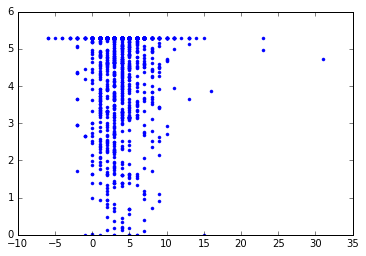

[[1.         0.03723521]
 [0.03723521 1.        ]]


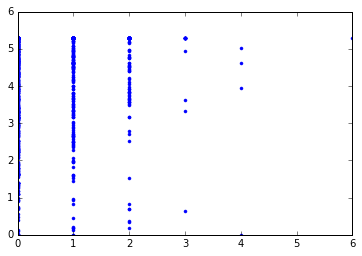

[[ 1.         -0.00175849]
 [-0.00175849  1.        ]]


In [789]:
charges = []
for seq in hemolysis_df.Sequence:
    charges.append(seq.count('K')+seq.count('R') - seq.count('E') - seq.count('D'))
plt.plot(charges,hemolysis_df.ln_HC50,'.')
plt.show()
print np.corrcoef(charges,hemolysis_df.ln_HC50)

ws = []
for seq in hemolysis_df.Sequence:
    ws.append(seq.count('N'))
plt.plot(ws,hemolysis_df.ln_HC50,'.')
plt.show()
print np.corrcoef(ws,hemolysis_df.ln_HC50)

In [827]:
for char in CHARACTER_DICT:
    counts = []
    for seq in cleaned_hemolysis_df.Sequence:
        counts.append(seq.count(char))
#     plt.plot(ws,hemolysis_df.ln_HC50,'.')
#     plt.show()
    print char +': '+ repr(np.corrcoef(counts,cleaned_hemolysis_df.log10_HC50)[0,1])

A: -0.06998906169845417
C: -0.01759162684145096
E: 0.09452578127690595
D: 0.038446262290412356
G: -0.0718318247905693
F: -0.09345430933931342
I: -0.1175629324484615
H: 0.04639300978888201
K: 0.05341748645171271
M: 0.043700071102789374
L: -0.2033334068207046
N: -0.0056547384490858756
Q: -0.00664707178765429
P: 0.0159442056175713
S: 0.021099649864485145
R: 0.027508646613986304
T: -0.0765479365911777
W: -0.07399751099877293
V: -0.04744541111426545
Y: 0.03902026158378757


In [689]:
print len(lengths)
print [lengths.count(i) for i in range(10)]

244
[0, 0, 148, 38, 14, 13, 18, 7, 2, 1]


In [598]:
sequence_dict['SWLRDLWDWICEVLSDFK']

[[3.0, 13.84, 'Equal', 'Equal']]